# <i>P. falciparum var</i> gene-tag classifications & analysis

### This notebook is a reproduction of the following paper: <br>

Githinji G & Bull PC (2017): <i>A re-assessment of gene-tag classification approaches for describing var gene expression patterns during human Plasmodium falciparum malaria parasite infections.</i> Wellcome Open Research 2017, 2:86. <br>

### The methods in the above paper are previously described in detail in the following papers, which I reference throughout this notebook: 

#### The ultimate paper on <i>P. falciparum var</i> genes that discuss var gene classifications: <br>

Rask TS, Hansen DA, Theander TG, et al. (2010): <i>Plasmodium falciparum erythrocyte membrane protein 1 diversity in seven genomes- divide and conquer.</i> PLoS Comput Biol. 2010; 6(9): pii: e1000933.

#### Bull PC's papers describing the Cys/PoLV and block-sharing group methods for DBL$\alpha$  tag classifications: <br> 

Bull PC, Kyes S, Buckee CO, et al. (2007): <i>An approach to classifying sequence tags sampled from Plasmodium falciparum var genes.</i> Mol Biochem Parasitol. 2007; 154(1): 98–102. <br>

Bull PC, Buckee CO, Kyes S, et al. (2008): <i>Plasmodium falciparum antigenic variation. Mapping mosaic var gene sequences onto a network of shared, highly polymorphic sequence blocks.</i> Mol Microbiol. 2008; 68(6): 1519–1534.


## DBL$\alpha$ Tag Sequences:

The DBL$\alpha$ tag sequences have been classified using 2 different approaches: 1) Cys/poLV groups and 2) block sharing groups (BS). <br>

<b>Approach #1:</b> Classify the tags using the number of cysteine residues in the sequences and the existence of mutually exclusive motifs: MFK and REY. <br>

<b>Approach #2:</b> Use network analysis to define sequence groups that tend to share position-specific blocks of sequence with each other. 

###  ◼  Approach #1. Classification of DBL$\alpha$ sequences: Cys/poLV groups 

**Dataset:** A total of 1,548 published DBL$\alpha$ sequences was obtained from Kilifi (Bull et al., 2008, n=1226) and from published parasite genomes (Rask et al., 2010, n=313), together with three DC8 sequences from a study conducted in Tanzania (Lavstsen et al., 2012) and six sequences from “sig2” sequences from (Bull et al., 2005b). All stored in FASTA file "1548_tags.fa".  <br>

**Source:** Githinji & Bull (2017): https://osf.io/uwcn2/ under "datasets."<br>

**Method described in detail in:** Bull PC, Kyes S, Buckee CO, et al. (2007): <i>An approach to classifying sequence tags sampled from Plasmodium falciparum var genes.</i> Mol Biochem Parasitol. 2007; 154(1): 98–102. <br>

**The idea:** Extract 2 features from DBL$\alpha$ sequences: number of cysteines and positions of limited variability (poLV) (based on mutually exclusive existence of motifs MFK at poLV1, REY at poLV2). If sequences of different length recombine with each other, they generate a wide range of sequences of different lengths, whereas genetically isolated sequences (those not recombining with each other) can maintain distinct distributions in their length. If these groupings are accurate, the sequences in each group should have similar lengths.  

**From Bull et al. (2007) (Figure 1A-E):** <br>

<img src="paper_figs/bull_2007_cyspolv.jpg">

<font size="1"> The cysteine/PoLV classification approach. (A) Sequence features extracted from DBL1α sequence tags. The input sequence is the DBL1α sequence starting from a DIGDI motif within homology block D and ending in PQFLR motif within homology block H (see Ref. [20]). Three features are used to group the sequences. These are (1) the PoLV1 motif situated at the 3′ end of homology block H (defined as the four amino acids starting 10 amino acids 3′ to the beginning of the DIGDI consensus), (2) the PoLV2 motif situated at the 5′ end of homology block F (defined as the four amino acids starting four amino acids 5′ to anchor point b or 12 amino acids 5′ to anchor point c, anchor points are marked with arrows), and (3) a count of the number of cysteine residues within the sequence. Two conserved internal anchor motifs “WW” and “VW” (anchor points b and c, respectively) were used to identify homology block F. The “WW” motif was confirmed to be present no more than once within all DBL1α sequence tags analysed. In sequences where the “WW” motif is absent due to sequencing or PCR errors the “VW” motif (anchor point c) is used as a backup. Groups were defined as described previously [9] (see box (*) any amino acid). The “distinct sequence identifier” DSID is defined as “PoLV1-PoLV2-PoLV3-number of cysteine residues in the sequence-PoLV4-sequence length”. (B–E) Length comparisons of sequences from different groups of sequence tags. The lengths of the sequence tags classified into different groups were compared between 10 studies. The studies were classified into four groups (a) Kenyan sequences from Kilifi, (b) non-Kenyan African sequences, (c) Asia Pacific sequences, and (d) South American sequences. The dotted line is placed to aid comparisons of sequence lengths (set at 120 amino acids). To avoid inclusion of the same sequence twice with minor differences due to PCR or sequencing errors, only “distinct” sequences were used from each of the 10 studies (i.e., only one sequence was included for each DSID counted within each individual study, see A). The number of distinct sequences are as follows: (a) Kenyan sequences: 606 sequences from Kilifi Kenya [9], (b) Other African sequences: 108 from Malawi (Montgomery, unpublished), 124 sequences from Mali [10], (c) Asia Pacific sequences: 162 from Papua New Guinea [7,17], 70 from The Solomon Islands [7], 53 from The Philippines [7], and (d) South American sequences: 49 from Venezuela [8], 148 from Brazil [6,18]. Example P values in comparisons of sequence length between groups are shown (Mann–Whitney U-test performed using Stata, Stata Corp, Texas, USA). </font>

#### Let's try to reproduce these results...

In [4]:
# Import statements #
import os
import re
import csv 
import json as js
import itertools
import numpy as np
import pandas as pd
from ggplot import *
import pylab as plt2
from Bio import SeqIO
import seaborn as sns
import networkx as nx
import matplotlib as mpl
import plotly.plotly as py
import matplotlib.pyplot as plt
from Bio.Alphabet import IUPAC
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

In [5]:
# FASTA file of 1548 Dbla sequences
base_path = "paper_datasets"
f = "1548_tags.fa"
filename = os.path.join(base_path, f)

First, we group sequences based on number of cysteines or "C"s present. <br>

- Use BioPython library to read & parse fasta file. 
- Initialize empty lists to store sequences with the appropriate number of cysteines.
    - Note that the list <b>cys5_records</b> stores sequences with 5 or more cysteines.
- Loop over each sequence to count the number of "C"s.
- Based on count of "C"s, add to the appropriate list.

In [3]:
# Initialize empty lists to store sequences & id/names
cys1_records = []
cys2_records = []
cys3_records = []
cys4_records = []
cys5_records = []
all_seqs = []
record_ids = []

# Loop over each sequence in file
for seq_record in SeqIO.parse(filename, "fasta"):
    
    # Append seq to list
    all_seqs.append(str(seq_record.seq))
    
    # Append id to list 
    record_ids.append(seq_record.id)
    
    # Loop over each sequence's letters, count occurences of "C"
    # If 1 "C", add record to 'cys1_records' and so on
    c_count = 0
    for aa in seq_record.seq:
        if aa == "C":
            c_count += 1

    # Add seq_record to appropriate records list
    if c_count == 1:
        cys1_records.append(seq_record)
    elif c_count == 2:
        cys2_records.append(seq_record)
    elif c_count == 3:
        cys3_records.append(seq_record)
    elif c_count == 4:
        cys4_records.append(seq_record)
    elif c_count >= 5:
        cys5_records.append(seq_record)
    else:
        cys5_records.append(seq_record)

Print 5 sample sequences from groups cys2 and cys4. This is in BioPython format, with sequence ID/name, number of features (0 for all), and the sequence truncated to fit on screen.

In [6]:
def print_seq(records_list, type_str, amount):
    print("\n")
    print("===========" + type_str + " SEQUENCES:=========== \n")
    n = len(records_list)
    for i in range(0, amount):
        print(records_list[i])
        print("\n")
    print(("." + "\n") * 3)
    print("\n")

print_seq(cys2_records, "CYS2", 5)
print_seq(cys4_records, "CYS4", 5)



===========CYS2 SEQUENCES:=========== 

ID: 001
Name: 001
Description: 001
Number of features: 0
Seq('DIADIIRGKDLYLGDQERKQHLEKRLETMFEKIQKNNNNKLSNLSTKEVREYWW...FFR', SingleLetterAlphabet())


ID: 002
Name: 002
Description: 002
Number of features: 0
Seq('DIGDIIGGKDLYLDHEQGYNRLEARLKTIFQNIQNKNKSPLDKLSLDKFREYWW...FLR', SingleLetterAlphabet())


ID: 005
Name: 005
Description: 005
Number of features: 0
Seq('DIGDIIRGIDMFKPNVHDKVEKGLREVFKKIHDLNKSKINDYDGDGPEYYKLRE...YLR', SingleLetterAlphabet())


ID: 020
Name: 020
Description: 020
Number of features: 0
Seq('DIGDIIRGKDLFIGYNEKDKEEKKQLQDNLKDIFKKIHNNLQDTEAQERYNGDG...YLR', SingleLetterAlphabet())


ID: 026
Name: 026
Description: 026
Number of features: 0
Seq('DIGDIIRGKDLFIGYNEKDRNEKKQLQDSLKKIFGKIYNELTNGRNGVKEHYKD...YLR', SingleLetterAlphabet())


.
.
.





===========CYS4 SEQUENCES:=========== 

ID: 003
Name: 003
Description: 003
Number of features: 0
Seq('DIGDIIRAKDLFIGYNQKDQNEKQKLQDSLKNIFGKIYEELSESAKEHYKKDKK...YLR', SingleLetterAlphabet())


I

Let's examine how many DBL$\alpha$ sequences are in each cysX group. Simple bar chart below.

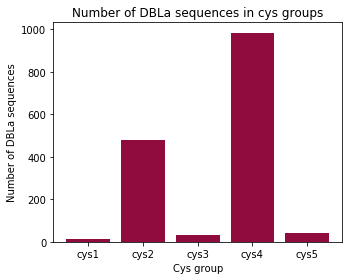

In [11]:
# Plot (x = cysX groups, y = number of sequences in each group)
x = list(range(1,6))
x_labels = ["cys1", "cys2", "cys3", "cys4", "cys5"]
y = [len(cys1_records), len(cys2_records), len(cys3_records),
     len(cys4_records), len(cys5_records)]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 10}
mpl.rc('font', **font)

plt.figure(figsize=(5,4))
plt.bar(x, y, align="center", color='#900C3F')
plt.xticks(x, x_labels)
plt.title('Number of DBLa sequences in cys groups')
plt.xlabel('Cys group')
plt.ylabel('Number of DBLa sequences')
plt.tight_layout()
plt.savefig('figures/cys_count.svg', format='svg', dpi=300)
plt.show()

As seen in the bar chart above, cys2 and cys4 groups have the most DBL$\alpha$ sequences. This explains the rationale of papers that have used these 2 cys groups as the main groups for cys/poLV classifications. So let's do the same below... <br>

Now, we further group the cysX groups into cys/poLV groups based on the following: <br>
- Group 1: cys2, poLV1 (MFK*)
- Group 2: cys2, poLV2 (*REY)
- Group 3: cys2, not in groups 1, 2
- Group 4: cys4, not group 5
- Group 5: cys4, poLV2 (*REY)
- Group 6: cys1, 3, 5, >5

Workflow: <br>
1. Group <font face="Courier">cys1_records, cys3_records, cys5_records</font> into <font face="Courier">group_6</font>
2. Loop through <font face="Courier">cys2_records</font> sequences:
    - If find "MFK" in sequence, add sequence to group 1
    - If find "REY" in sequence, add sequence to group 2
    - Else (no "MFK" and no "REY"), add sequence to group 3 <br>
    
3. Repeat step 2 for <font face="Courier">cys4_records</font> sequences

In [13]:
"""
1. Group 6 = cys1, 3, 5, >5
"""
group_6 = cys1_records + cys3_records + cys5_records

######################################################################

"""
 2. Group 1: cys2, poLV1 (MFK*)
    Group 2: cys2, poLV2 (*REY)
    Group 3: cys2, not in groups 1, 2
"""

group_1 = []; group_1_id = [];
group_2 = []; group_2_id = [];
group_3 = []; group_3_id = [];

for record in cys2_records:

    # search for "MFK" in sequence, if found, add to group 1
    if "MFK" in record.seq:
        group_1.append(record)
        group_1_id.append(record.id)

    # search for "REY" in sequence, if found, add to group 2
    elif "REY" in record.seq:
        group_2.append(record)
        group_2_id.append(record.id)
        
    # if neither "MFK" nor "REY" present, add to group 3
    else:
        group_3.append(record)
        group_3_id.append(record.id)
######################################################################

"""
 3. Group 4: cys4, not group 5
    Group 5: cys4, poLV2 (*REY)
"""
group_4 = []; group_4_id = [];
group_5 = []; group_5_id = [];

for record in cys4_records:
    if "REY" in record.seq:
        group_5.append(record)
        group_5_id.append(record.id)

    else:
        group_4.append(record)
        group_4_id.append(record.id)

Create a list of cys/polv classifications for all sequences, in the same order as the tags are in the fasta file. Comparing this list "cyspolv_classif" to the Cys/PoLV column of "curated_data_set.csv" of Githinji & Bull (2017), they are the same and we confirm that the Cys/PoLV classification is reproducible. 

In [14]:
cyspolv_classif = []

for i in range(len(record_ids)):
    if record_ids[i] in group_1_id:
        cyspolv_classif.append(1)
    elif record_ids[i] in group_2_id:
        cyspolv_classif.append(2)
    elif record_ids[i] in group_3_id:
        cyspolv_classif.append(3)
    elif record_ids[i] in group_4_id:
        cyspolv_classif.append(4)
    elif record_ids[i] in group_5_id:
        cyspolv_classif.append(5)
    else: 
        cyspolv_classif.append(6)

Some example sequences from each cys/poLV group. All sequences in dataset begin with "DIGDI" in maroon. "MFK" and "REY" motifs are highlighted blue. <br>

**An issue:** Sequence 1 from group 1 has both "MFK" and "REY." Aren't they mutually exclusive? Are the rest of dataset ok? <br>

**Things to consider:** Must we take into account the varying lengths of the sequences? 

In [15]:
# Example sequences from each group:
print("\nSAMPLE SEQUENCES FROM 6 CYSTEINE/POLV GROUPS: \n")

print("GROUP 1: cys2, poLV1 (MFK*)")
print(str(group_1[1].seq).replace("MFK", '\033[44m{}\033[m'.format("MFK")).replace("DIGDI", '\033[5;91m{}\033[m'.format("DIGDI")) + "\n")

print("GROUP 2: cys2, poLV2 (*REY)")
print(str(group_2[1].seq).replace("REY", '\033[44m{}\033[m'.format("REY")).replace("DIGDI", '\033[5;91m{}\033[m'.format("DIGDI")) + "\n")

print("GROUP 3: cys2, not in groups 1, 2")
print(str(group_3[1].seq).replace("DIGDI", '\033[5;91m{}\033[m'.format("DIGDI")) + "\n")

print("GROUP 4: cys4, not group 5")
print(str(group_4[1].seq).replace("DIGDI", '\033[5;91m{}\033[m'.format("DIGDI")) + "\n")

print("GROUP 5: cys4, poLV2 (*REY)")
print(str(group_5[1].seq).replace("REY", '\033[44m{}\033[m'.format("REY")).replace("DIGDI", '\033[5;91m{}\033[m'.format("DIGDI")) + "\n")

print("GROUP 6: cys1, 3, 5, >5")
print(str(group_6[1].seq).replace("DIGDI", '\033[5;91m{}\033[m'.format("DIGDI")) + "\n")



SAMPLE SEQUENCES FROM 6 CYSTEINE/POLV GROUPS: 

GROUP 1: cys2, poLV1 (MFK*)
DIGDIIRGKDLFLGHNQRKKKLEKRLEQMFKNIKKNNDELDKISIERVREYWWALNRQDVWKAITCRAGDTDEYFTKSSDGLYVFSNGPCGRDETDVPTNLDYVPQFLR

GROUP 2: cys2, poLV2 (*REY)
DIGDIIGGKDLYLDHEQGYNRLEARLKTIFQNIQNKNKSPLDKLSLDKFREYWWALNRVQVWKAITCKAEVDDIYSKTANGNTTLWNYNCGHHVNQDVPANLDYVPQFLR

GROUP 3: cys2, not in groups 1, 2
DIGDIIRGKDLFIGYNEKDRNEKKQLQDSLKKIFGKIYNELTNGRNGVKEHYKDEDDNEGNYFQLREDWWNANRKEVWKAITCKADENDRYSANIEHDRTGVSHGRCGHRDENVPTYLDYVPQYLR

GROUP 4: cys4, not group 5
DIGDIIRGKDLFIGNNKRDKLEKQLKKYFNNIYEQLVKKDEEGAETHYEGDEANNFFQLREDWWNANRQEIWKAITCDDRLGGNAYFRRTCGGNEKNSTLAKDKCRCKDENGKPNDQVPTYFDYVPQYLR

GROUP 5: cys4, poLV2 (*REY)
DIGDIIRGKDLFLGHKQRKIQLEERLKTMFENIQENNYSTLKTLSIDAVREYWWALNRDQVWNAITCKAPDNAKYFRGTCGGDARKPSLTQNNCRCKGDQVPTYFDYVPQYPR

GROUP 6: cys1, 3, 5, >5
DIGDIVRGRDMFKPNEEDAVQKGLRAVFKKIHDKLKQPEKDYYNADEKGNYYKLRDAWWTVNRNQVWEAITYKAPRKADYFRNISKRIRGFTDIGKCGHNKGSVPTYLDYVPQFLR



To test the Bull et al., 2007 hypothesis that sequences in the same cys/poLV group have similar sequence lengths, let's create a dataframe containing the group names and the lengths of the sequences within each group. Below, a swarm plot to visualize distribution of sequence lengths among groups:

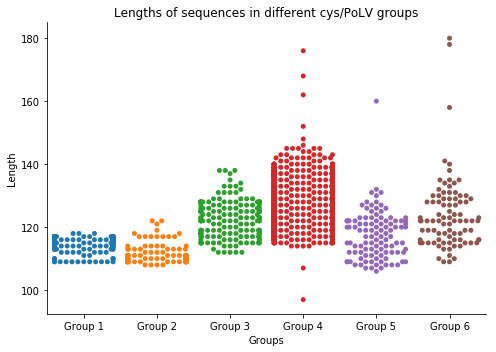

In [16]:
# Concatenate all groups into 1 list
all_groups = [group_1, group_2, group_3, group_4, group_5, group_6]

# Create dataframe for seaborn plot
group_values = []
for group_i, group in enumerate(all_groups):
    sequence_lengths = []
    for sequence in group:
        seq_length = len(sequence)
        sequence_lengths.append(seq_length)

    group_values.append(np.array(sequence_lengths))

group_values = np.array(group_values)
group_ids = ["Group {}".format(i+1) for i in range(len(all_groups))]

data_x = []
for i, group_id in enumerate(group_ids):
    group_i = group_values[i]
    for datum in group_i:
        data_point = [datum, group_id]
        data_x.append(data_point)

df = pd.DataFrame(data=data_x, columns=["Length", "Groups"])

# Plotting time
plt.figure(figsize=(7,5))
sns.color_palette("Set2", 6)
g = sns.swarmplot(x="Groups", y="Length", data=df).set_title("Lengths of sequences in different cys/PoLV groups")
sns.despine()
plt.tight_layout()
plt.savefig('figures/cp_length.svg', format='svg', dpi=300)
plt.show()

This global plot (for all tag sequences in dataset) is similar to the Bull et al. (2007) Figure 1(B-E)!

### ◼ Approach #2 Classification of DBL$\alpha$ sequence: Block-sharing groups & networks

**Dataset:** Same as #1

**Source:** Same as #1

**Method described in:** Githinji & Bull (2017) & Bull PC, Buckee CO, Kyes S, et al. (2008): <i>Plasmodium falciparum antigenic variation. Mapping mosaic var gene sequences onto a network of shared, highly polymorphic sequence blocks.</i> Mol Microbiol. 2008; 68(6): 1519–1534.

**The idea:** Sequence mosaicism within var gene sequences can easily be recognized through visual inspection of sequences. Blocks of sequence are frequently shared between two otherwise dissimilar sequences within regions of the sequence that are normally highly polymorphic. <br>

Consider: DBL$\alpha$ sequence tags are highly variable in length. <br>

Standard approaches: Alignment of sequences by introducing gaps (Fig. 1A). Issue: Possible inaccurate alignment. <br>

Githinji & Bull's proposal: Restrict analysis to ungapped polymorphic sequence blocks at locations within var sequence tags that were fixed relative to one of three conserved anchor points, one at each end and one in the middle (highlighted with a black background in Fig. 1B). This provides 4 window positions. Using only sequence within these windows we then simply asked whether two sequences were identical within any one of the sequence blocks. This treats each sequence as multiple independent blocks of sequence each acting as genetic markers for the sequence to which they are anchored. Each sequence block is a ‘position specific polymorphic block’ (PSPB). The PSPBs are used to construct networks in which sequences are represented by nodes (vertices) that are joined by lines (edges) if they are identical at one or more of their constituent PSPBs (each is 10-aa long). <br>

After we have the block-sharing network, block-sharing groups (primarily 1 & 2) are identified by observing the sharing of 14-aa blocks within DBLa tags from parasites from Kenyan children to find the 2 largest components: block-sharing group 1 (BS1) and 2 (BS2). 

**From Bull et al. (2008) (Figure 1A-B): Finding PSPBs within sequences** <br>

<img src="paper_figs/bull_2008_bs.jpg">

<font size="1">The rationale for the approach. A and B. A Clustal alignment of four var sequences from 3D7 genome. Comparison of genes would normally be based on an alignment of the regions that are most shared between different sequences. The alternative used here (B) is to align polymorphic blocks of sequence (orange) to fixed reference points that are known to be invariant (black shaded sequence). For this, alignment of some conserved residues (one example is highlighted in blue) takes lower priority than alignment with respect to the chosen anchor points. These ‘position specific polymorphic blocks’ (PSPBs) are defined at up to four positions, PSPBs1–4. The default start positions (positions closest to the anchor point) are shown with vertical arrows. We chose default positions for the PSPBs that were adjacent to, but did not overlap with previously defined ‘positions of limited variability’ (PoLV1-4) marked 1, 2, 3 and 4 respectively (Bull et al., 2005; 2007).</font>


**From Githinji & Bull (2017) (Figure 4): Block-sharing networks and analyses of tags via various classifications** <br>

<img src="paper_figs/githinji_2017_networks.jpg">

<font size="1">Network analysis of DBLα tag sequences collected from Kilifi (Bull et al., 2008), 6 laboratory isolates (Rask et al.,2010) and Tanzanian (Lavstsen et al., 2012). The analysis builds on that described in (Bull et al., 2008). (a) Cys/polv analysis for all sequences; (b) block sharing groups analysis for all sequences; (c) Cys/polv analysis for full length var gene sequences from 6 laboratory isolates; (d) block sharing groups analysis for full length var gene sequences from 6 laboratory isolates; (e) ups grouping for full length
var gene sequences from 6 laboratory isolates; (f) domain cassette (DC) classification for DC4, DC5, DC8 and DC13 for full length var gene sequences from 6 laboratory isolates; (g) predicted EPCR-binding phenotype due to CIDRα1.1, CIDRα1.4, CIDRα1.5, CIDRα1.6, CIDRα1.7 or CIDRα1.8 (Lau et al., 2015) for sequences with CIDRα information available; (h) predicted CD36-binding phenotype due to CIDRα2, CIDRα3, CIDRα4, CIDRα5 (Robinson et al., 2003) for sequences with CIDRα information available. Colours of vertices match those defined in Figure 1: a and c) brown = cys/polv group 1 (CP1), red= CP2, yellow = CP3, blue = CP4, light-blue = CP5, grey = CP6; b and d) pink = block sharing group 1 (BS1), black = BS2, white = not a member of a block sharing group; e) orange = upsA, purple = upsB, light green = upsC; f) black = domain cassette 8 (DC8), red = DC5, pink = DC13, yellow = DC4; g) black = predicted EPCR binding; h) black</font>

#### First, let's find the PSPBs in all 1548 tag sequences:
Before making the block-sharing network to group together sequences that have the same 10-aa blocks, we create the blocks based on Bull et al. (2008): <br>
1. Identify 3 fixed reference points (blacked-shaded in Bull (2008) figure 1B) at the 2 ends and in the middle: D, WW (or W followed by another amino acid), and R.
2. Extract 4 blocks of amino acids from the windows defined by the 3 reference points. Default positions for the PSPBs are: 
    - the 5' aa of PSPB1 is set 15 aa from the 5' of the tag region
    - the 3' end of PSPB2 is set 5 aa from 5' to the central WW motif
    - the 5' end of PSPB3 is set 13 aa 3' to the central WW motif
    - the 3' end of PSPB4 is set 13 aa from the 5' end of the tag region 
    
Then we generate a csv file ("PSPB_10aa.csv") to hold info of the sequences: the node (index from 0-1547 for 1548 sequences/nodes total), tag # (aka seq_record.id), PSPB1, PSPB2, PSPB3, PSPB4, dbla sequence. This csv file is in the same format as the "mmi0068-1519-SD30.xls" file from Bull et al. (2008), which have less sequences but should be identical to "PSPB_10aa.csv" otherwise.

In [17]:
# Initialize ordered lists to be written to "PSPB_10aa.csv"
nodes = [x for x in range(0,1549)]
tags = [] 
PSPB1_list = []
PSPB2_list = []
PSPB3_list = []
PSPB4_list = []
dbla_seq = []

In [18]:
# The 3 fixed reference points for all sequences:
ref1 = "D"
# ref2 = "WW" Not used because this could vary, always starts with W but may be followed by various aa's
ref3 = "R"

# Find ref points in each seq, extract 4 PSPBs, add to lists
for seq_record in SeqIO.parse(filename, "fasta"):
    
    # Turn seq in Biopython format to string
    seq_record.seq = str(seq_record.seq)
    
    ### 1. Get positions of the 3 reference points in each sequence ###
    
    # Ref1: Index should be 0 for all ref1
    d_index = seq_record.seq.find(ref1)    
    
    # Ref2: Use regex to find [W + any other aa, usually another W]
    find_ww = re.search(r"[W][A-Z]{1}", seq_record.seq)
    ww_indices = find_ww.span() # a tuple, index [o] or [1]
    
    # Ref3: Should be last index of each sequence
    r_index = seq_record.seq.rfind(ref3)    

    ### 2. Extract the 4 PSPBs (use negative indexing for 3' direction) ###
    PSPB1 = seq_record.seq[(d_index + 14) : (d_index + 14 + 10)]    
    PSPB2 = seq_record.seq[(ww_indices[0] - 14) : (ww_indices[0] - 4)]
    PSPB3 = seq_record.seq[(ww_indices[1] + 12) : (ww_indices[1] + 12 + 10)]
    PSPB4 = seq_record.seq[(r_index - 21) : (r_index - 11)]
    
    ### 3. Write to csv the info of this single sequence ###
    tags.append(seq_record.id)
    dbla_seq.append(seq_record.seq)
    PSPB1_list.append(PSPB1)
    PSPB2_list.append(PSPB2)
    PSPB3_list.append(PSPB3)
    PSPB4_list.append(PSPB4)

Write nodes, tags, PSPBs 1-4, and sequences to "PSPB_10aa.csv" file.

In [19]:
rows = zip(nodes, tags, PSPB1_list, PSPB2_list, PSPB3_list, PSPB4_list, dbla_seq)
with open('processed_datasets/PSPB_10aa.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["Node", "Tag", "PSPB1", "PSPB2", "PSPB3", "PSPB4", "Dbla Sequence"])
    for row in rows:
        writer.writerow(row)

#### Now, let's create the block-sharing network structure

Find sequences that are identical at at least 1 PSPB. Comprehensive pairwise comparison of sequences is used. Pairs of sequences that match in at least 1 PSPB is an "edge" or connection in the network.

In [20]:
# Main data dictionary to write:
data = {}

In [21]:
# Function to merge lists composed of lists
def merge_lists(list_of_lists):
    new_list = []
    for elem in list_of_lists:
        new_list += elem        
    return new_list

In [22]:
# Function to create a list of tuples/edges to make network
def get_edges(PSPB1_list, PSPB2_list, PSPB3_list, PSPB4_list):
    
    # Identify sequences (by indices) that share PSPBs:
    find = lambda searchList: [[i for i, x in enumerate(searchList) if x == e] for e in searchList]
    
    matches1 = find(PSPB1_list)
    matches2 = find(PSPB2_list)
    matches3 = find(PSPB3_list)
    matches4 = find(PSPB4_list)
    # print(matches1) -> Ex: [[0, 120, 121, 425], [1, 107], [2],...]

    # Create list of tuples from the above matchesX lists
    edges_1 = []
    edges_2 = []
    edges_3 = []
    edges_4 = []

    for node_i in range(0, len(matches1)):
        edges1 = list(itertools.combinations(matches1[node_i], 2))
        edges2 = list(itertools.combinations(matches2[node_i], 2))
        edges3 = list(itertools.combinations(matches3[node_i], 2))
        edges4 = list(itertools.combinations(matches4[node_i], 2))

        edges_1.append(edges1)
        edges_2.append(edges2)
        edges_3.append(edges3)
        edges_4.append(edges4)
    # print(edges_1) -> Ex: [[(0, 120), (0, 121), (0, 425), (120, 121), (120, 425), (121, 425)], [(1, 107)], [], ...]
    
    
    # Merging all 4 list of tuples into a giant list of tuples
    merged_edges = list(sorted(set(merge_lists(edges_1) + merge_lists(edges_2) + merge_lists(edges_3) + merge_lists(edges_4))))
    
    # Map each tuple to where they matched: PSPB1, 2, 3, or 4
    # Create dict: key-value -> "edge": (tuple), "pspb_matches": [pspb matches]
    # Use set function to omit duplicate tuples
    pspb_matches = [list(set(merge_lists(edges_1))), list(set(merge_lists(edges_2))), list(set(merge_lists(edges_3))), list(set(merge_lists(edges_4)))]
    
    # A list that holds dictionary of keys "edge" and "pspb_matches"
    edges = []
    for merged_edge in merged_edges:
        PSPBs = []
        for pspb_i, pspb in enumerate(pspb_matches, 1):
            if merged_edge in pspb:
                PSPBs.append("PSBP{}".format(pspb_i))
        edges.append({"edge" : merged_edge, "pspb_matches" : PSPBs})

    return edges

In [23]:
# Call get_edges function to create list of tuples/edges
edges = get_edges(PSPB1_list, PSPB2_list, PSPB3_list, PSPB4_list)

In [24]:
print("Example of an element in the list 'edges':")
edges[3]

Example of an element in the list 'edges':


{'edge': (0, 121), 'pspb_matches': ['PSBP1', 'PSBP2', 'PSBP4']}

In [25]:
# Add the above edge info ("edges" list) to main dict, data: 
data["edges_info"] = edges

In [26]:
print("Example of an edge's info in the dict 'data':")
data["edges_info"][35]

Example of an edge's info in the dict 'data':


{'edge': (3, 744), 'pspb_matches': ['PSBP1', 'PSBP4']}

#### Finally, we use 14-aa long PSPBs to create the block-sharing group classification and find block-sharing groups 1 & 2

Approach:
- Find 14-aa PSPBs in tag sequences. The papers did not describe this in detail, but from inference, this is the workflow:
    1. Identify 3 fixed reference points (blacked-shaded) at the 2 ends and in the middle: D, WW (or W followed by another amino acid), and R.
    2. Extract 4 blocks of amino acids from the windows defined by thr 3 reference points. Default positions for the PSPBs are: 
        - the 5' aa of PSPB1 is set 15 aa from the 5' of the tag region
        - the 3' aa of PSPB1 is set 15 + 14 aa away from the 5' of the tag region
        - the 3' end of PSPB2 is set 5 aa from 5' to the central WW motif
            - the 5' end of PSPB2 is set 5 + 14 aa away 
        - the 5' end of PSPB3 is set 13 aa 3' to the central WW motif
            - the 3' end of PSPB3 is set 13 + 14 aa away
        - the 3' end of PSPB4 is set 13 aa from the 5' end of the tag region 
        - the 5' end of PSPB4 is set 13 + 14 aa away
                
- Find sequences that share the blocks. Add info to "PSPB_14aa.csv."
- Create network and find the 2 largest components: These are the block-sharing groups 1 & 2 (BS1 & BS2)

In [27]:
# The 3 fixed reference points for all sequences:
ref1 = "D"
ref3 = "R"


# Lists to write to csv "PSPB_14aa.csv"
nodes_14aa = [x for x in range(0,1549)]
tags_14aa = [] 
dbla_seq_14aa = []
PSPB1_14aa = []
PSPB2_14aa = []
PSPB3_14aa = []
PSPB4_14aa = []


# Find ref points in each seq, extract 4 PSPBs, add to lists
for seq_record in SeqIO.parse(filename, "fasta"):
    
    # Turn seq in Biopython format to string
    seq_record.seq = str(seq_record.seq)
    
    ### 1. Get positions of the 3 reference points in each sequence ###
    
    # Ref1: Index should be 0 for all ref1
    d_index = seq_record.seq.find(ref1)    
    
    # Ref2: Use regex to find [W + any other aa, usually another W]
    find_ww = re.search(r"[W][A-Z]{1}", seq_record.seq)
    ww_indices = find_ww.span() # a tuple, index [o] or [1]
    
    # Ref3: Should be last index of each sequence
    r_index = seq_record.seq.rfind(ref3)    

    ### 2. Extract the 4 PSPBs (use negative indexing for 3' direction) ###
    PSPB1 = seq_record.seq[(d_index + 14) : (d_index + 14 + 14)]
    PSPB2 = seq_record.seq[(ww_indices[0] - 18) : (ww_indices[0] - 4)]
    PSPB3 = seq_record.seq[(ww_indices[1] + 12) : (ww_indices[1] + 12 + 14)]
    PSPB4 = seq_record.seq[(r_index - 25) : (r_index - 11)]
    
    ### 3. Write to csv the info of this single sequence ###
    tags_14aa.append(seq_record.id)
    dbla_seq_14aa.append(seq_record.seq)
    PSPB1_14aa.append(PSPB1)
    PSPB2_14aa.append(PSPB2)
    PSPB3_14aa.append(PSPB3)
    PSPB4_14aa.append(PSPB4)

Write nodes, tags, PSPBs 1-4, and sequences to "PSPB_14aa.csv" file.

In [21]:
rows_14aa = zip(nodes_14aa, tags_14aa, PSPB1_14aa, PSPB2_14aa, PSPB3_14aa, PSPB4_14aa, dbla_seq_14aa)
with open('processed_datasets/PSPB_14aa.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["Node", "Tag", "PSPB1", "PSPB2", "PSPB3", "PSPB4", "Dbla Sequence"])
    for row in rows_14aa:
        writer.writerow(row)

Using block-sharing groups classification of tag sequences in Bull et al. (2008) perl script "mmi0068-1519-SD3.pl" to assign sequences to block-sharing groups 1 or 2. Sequences not in either is classified as 0. <br>

Note that we extracted the lists of PSPBs from the perl script and converted them to lists of strings. This is all stored in the file "bs_groups.txt."

In [28]:
# Open and obtain the PSPBs
with open("processed_datasets/bs_groups.txt") as f:
    content = f.readlines()
content = [x.strip().replace('[','').replace(']','').split(",") for x in content] 
content.remove([''])

# Put file lines into a list
content = [x for x in content if x != ['']]

In [29]:
# These lists hold the PSPBs for BS groups 1 & 2
bs1_pspb = merge_lists(content[0:4])
bs2_pspb = merge_lists(content[4:])

In [30]:
# Check if each tag seq has the subseq from BS1 and BS2
N = len(all_seqs)
bs_list = np.zeros(N)
for node_i, sequence in enumerate(all_seqs):
    # Check bs1_pspb for match
    for subseq_bs1 in bs1_pspb:
        if subseq_bs1 in sequence:
            bs_list[node_i] = 1

    
    # Check bs2_pspb for match
    for subseq_bs2 in bs2_pspb:
        if subseq_bs2 in sequence:
            bs_list[node_i] = 2

In [31]:
'''
Compare the above created list "bs_list" with the block sharing
partition list in "97ba7a0f-da43-49dd-a01f-2c047a44535f.paj" file 
from Githinji. We converted the .paj file to .txt for easy reading 
into Python. 
'''

found = False
real_data_list = []
with open("processed_datasets/data.txt", "r") as infile:
    for line in infile:
        # "HERE HERE" in the file notes where the BS list begins
        if "HERE HERE" in line:
            found = True
        
        if "*Partition" in line and found:
            found = False
            
        if found:
            try:
                real_data_list.append(int(line.strip()))
            except:
                pass
    
real_data_list = np.array(real_data_list)

In [32]:
# Are the list we created and the authors' list the same?
lists_same = np.array_equal(bs_list, real_data_list)
print("Lists are same: {}".format(lists_same))

Lists are same: True


## Figures: Relationships between  DBL$\alpha$ tags and full <i>var</i> sequences

Below are reproduction of the figures in Githinji & Bull (2017) in the same order as the paper. Because we've confirmed above that the cys/poLV and block-sharing classifications were successfully reproduced, for the visualizations below we use the data from Githinji & Bull (2017) file "curated_data_set.csv" because it also includes full-length var gene classifications. <br>

### ▶ Visualization 1: Bar graphs

In [33]:
# Read in curated dataset
curated_data = pd.read_csv('paper_datasets/curated_data_set.csv')
curated_data.head(5)

,No,Name,HB_219,HB_204,HB_204_219,First_CIDR,CIDRinfo_3,EPCR_3,CD36_3,cys_PoLV_group,...,sample,ups,upsinfo,ups_clu,domain,cassette,"DC8,13,4,5",DC8,DBLb,gene_length
0,1275,DD2var47,0,0,0,CIDRa1.1,1,1,0,3,...,3,B,1,2,DBLa2,DC8,1,1,DBLb12,9021
1,1338,IGHvar19,0,0,0,CIDRa1.1,1,1,0,3,...,7,B,1,2,DBLa2,DC8,1,1,other,9387
2,1364,IT4var06,0,0,0,CIDRa1.1,1,1,0,4,...,4,B,1,2,DBLa2,DC8,1,1,other,9453
3,1374,IT4var19,0,0,0,CIDRa1.1,1,1,0,4,...,4,B,1,2,DBLa2,DC8,1,1,DBLb12,10119
4,1375,IT4var20,0,0,0,CIDRa1.1,1,1,0,3,...,4,B,1,2,DBLa2,DC8,1,1,DBLb12,9021


In [34]:
# Put all column titles into a list
keys = list(curated_data.columns[0:])

In [35]:
# Turn each column of interest into a list

# Initialize lists
# general info: 
No = []; Name = [];  sequence = []; genome = [] 
# var gene classifs:
domain = []; cassette = []; CIDR = [] 
# var tag classifs:
ups = []
cys_PoLV_group = []
BS_group1 = []; BS_group2 = []
HB_219 = []; HB_204 = []

# Append to lists 
for x in range(len(curated_data["No"])):
    No.append(curated_data["No"][x])
    Name.append(curated_data["Name"][x])
    sequence.append(curated_data["sequence"][x])
    genome.append(curated_data["genome"][x])
    
    domain.append(curated_data["domain"][x])
    cassette.append(curated_data["cassette"][x])
    CIDR.append(curated_data["First_CIDR"][x])
    
    ups.append(curated_data["ups"][x])
    cys_PoLV_group.append(curated_data["cys_PoLV_group"][x])
    BS_group1.append(curated_data["BS_group1"][x])
    BS_group2.append(curated_data["BS_group2"][x])
    HB_219.append(curated_data["HB_219"][x])
    HB_204.append(curated_data["HB_204"][x])

# Put all lists into one list    
combined_lists = No, Name, HB_219, HB_204, cys_PoLV_group, BS_group1, BS_group2, sequence, ups

In [36]:
# Initialize dicts for var gene classifs
dbla_dict = {}; cassette_dict = {}; cidr_dict = {}

In [37]:
# Find out how many unique items in each list of var gene classifs
# Only extract the first 313 sequences with gene classifs info
dbla_uniques = list(sorted(set(domain[:313])))
cassette_uniques = list(sorted(set(cassette[:313])))
CIDR_uniques = list(sorted(set(CIDR[:313])))

In [38]:
# Append to dicts the classes of each classif
for i in dbla_uniques:
    dbla_dict[i] = {}
for i in cassette_uniques:
    cassette_dict[i] = {}
for i in CIDR_uniques:
    if i != "missing information" and i != "var3":
        cidr_dict[i] = {}
    else: continue

In [39]:
# Function to count instances of each ups class & return proportions
def count_ups(ups_list, domain_list, dbla):

    count_A = 0; count_B = 0; count_C = 0

    for i in range(len(ups_list)):
        if domain_list[i] == dbla:
            if ups_list[i] == "A":
                count_A += 1
            elif ups_list[i] == "B":
                count_B += 1
            elif ups_list[i] == "C":
                count_C += 1
                
    ups_total = count_A + count_B + count_C
    ups_props = [count_A/ups_total, count_B/ups_total, count_C/ups_total]
    
    return ups_props

In [40]:
# Function to count instances of each cys/polv class & return proportions
def count_cp(cp_list, domain_list, dbla):
    
    count_1 = 0; count_2 = 0; count_3 = 0; count_4 = 0; count_5 = 0; count_6 = 0

    for i in range(len(cp_list)):
        if domain_list[i] == dbla:
            if cp_list[i] == 1:
                count_1 += 1
            elif cp_list[i] == 2:
                count_2 += 1
            elif cp_list[i] == 3:
                count_3 += 1
            elif cp_list[i] == 4:
                count_4 += 1
            elif cp_list[i] == 5:
                count_5 += 1
            elif cp_list[i] == 6:
                count_6 += 1
    
    cp = [count_1,count_2,count_3,count_4,count_5,count_6]
        
    cp_total = count_1 + count_2 + count_3 + count_4 + count_5 + count_6
    
    cp_props = []
    for i in cp:
        cp_props.append(i/cp_total)
        
    return cp_props

In [41]:
# Function to count instances of each HB class & return proportions
def count_hb(hb204_list, hb209_list, domain_list, dbla):
    
    count_hb204 = 0; count_hb219 = 0; count_all = 0
    
    for i in range(len(hb204_list)):
        if domain_list[i] == dbla:
            count_all += 1
            if hb204_list[i] == 1:
                count_hb204 += 1
            elif hb209_list[i] == 1:
                count_hb219 += 1
                
    other = 1 - (count_hb204/count_all + count_hb219/count_all)
    hb_props = [count_hb204/count_all, count_hb219/count_all, other]
    
    return hb_props     

In [42]:
# Function to count instances of each BS class & return proportions
def count_bs(BS_group1, BS_group2, domain_list, dbla):
    
    count_bs1 = 0; count_bs2 = 0; count_all = 0
    
    for i in range(len(BS_group1)):
        if domain_list[i] == dbla:
            count_all += 1
            if BS_group1[i] == 1:
                count_bs1 += 1
            elif BS_group2[i] == 1:
                count_bs2 += 1

    none = 1 - (count_bs1/count_all + count_bs2/count_all)
    bs_props = [count_bs1/count_all, count_bs2/count_all, none]
    
    return bs_props                        

Write to the 3 dicts the proportions of each class of each classification:

In [43]:
for key in dbla_dict.keys():
    dbla_dict[key] = {
                    "ups":count_ups(ups, domain, key),
                    "cp":count_cp(cys_PoLV_group, domain, key),
                    "hb":count_hb(HB_204, HB_219, domain, key),
                    "bs":count_bs(BS_group1, BS_group2, domain, key)}


In [44]:
for key in cassette_dict.keys():
    cassette_dict[key] = {
                    "ups":count_ups(ups, cassette, key),
                    "cp":count_cp(cys_PoLV_group, cassette, key),
                    "hb":count_hb(HB_204, HB_219, cassette, key),
                    "bs":count_bs(BS_group1, BS_group2, cassette, key)}

In [45]:
for key in cidr_dict.keys():
    cidr_dict[key] = {
                    "ups":count_ups(ups, CIDR, key),
                    "cp":count_cp(cys_PoLV_group, CIDR, key),
                    "hb":count_hb(HB_204, HB_219, CIDR, key),
                    "bs":count_bs(BS_group1, BS_group2, CIDR, key)}


Create keys list to match the order of the classes (x-axes) in Githinji & Bull (2017) Figure 1,2,3:

In [46]:
dbla_keys = ["DBLa1.1", "DBLa1.3", "DBLa1.4", "DBLa1.5", "DBLa1.7", "DBLa1.8",
               "DBLa1.2", "DBLa1.6", "DBLa0.10", "DBLa0.12", "DBLa0.13", "DBLa0.14",
               "DBLa0.3", "DBLa0.6", "DBLa0.7", "DBLa2", "DBLa0.9", "DBLa0.11", 
               "DBLa0.8", "DBLa0.5", "DBLa0.16", "DBLa0.15", "DBLa0.2", "DBLa0.22",
               "DBLa0.23", "DBLa0.18", "DBLa0.1", "DBLa0.4", "DBLa0.17", "DBLa0.20",
               "DBLa0.21", "DBLa0.19", "DBLa0.24"]

cassette_keys = ["DC1", "DC11", "DC13", "DC15", "DC3", "DC4", "DC5",
                 "DC16", "DC12", "DC6", "DC10", "DC14", "DC18",
                 "DC8", "DC9", "DC17", "DC20", "DC7", "DC0", 
                 "DC19", "DC21", "DC22"]

cidr_keys = ["CIDRa1.2", "CIDRa1.3", "CIDRa1.4", "CIDRa1.5",
             "CIDRb2", "CIDRb4", "CIDRg3", "CIDRd1", 
             "CIDRa1.7", "CIDRd2", "CIDRa1.6", "CIDRa1.1", "CIDRa1.8", 
             "CIDRa2.11", "CIDRa2.2", "CIDRa2.9", "CIDRa2.5", 
             "CIDRg7", "CIDRa4", "CIDRa2.4", "CIDRa5",
             "CIDRa2.7", "CIDRa2.8", "CIDRa3.4", "CIDRa2.6",
             "CIDRa3.5", "CIDRa2.3", "CIDRa3.2", "CIDRa3.1",
             "CIDRa6", "CIDRa2.1", "CIDRa3.3", "CIDRa2.10"]

In [47]:
# Create ordered lists of gene classifs based on the ordered keys above:
dbla_list = []
cassette_list = []
cidr_list = []

for key in dbla_keys:
    if key in dbla_dict.keys():
        dbla_list.append(dbla_dict[key])
for key in cassette_keys:
    if key in cassette_dict.keys():
        cassette_list.append(cassette_dict[key])
for key in cidr_keys:
    if key in cidr_dict.keys():
        cidr_list.append(cidr_dict[key])

In [63]:
# Function to make ups bar graph
def ups_bar(x_list, orderedkeys_list):
    upsA = []; upsB = []; upsC = []
    for d in x_list:
        upsA.append(d["ups"][0])
        upsB.append(d["ups"][1])
        upsC.append(d["ups"][2])
     
    # Make plot
    ind = [x for x, _ in enumerate(orderedkeys_list)]

    plt.figure(figsize=(25,7))

    font = {'family' : 'DejaVu Sans',
            'weight' : 'normal',
            'size'   : 20}

    mpl.rc('font', **font)

    plt.bar(ind, upsA, width=0.8, label='ups-A', color='darkorange', bottom=np.array(upsB)+np.array(upsC))
    plt.bar(ind, upsB, width=0.8, label='ups-B', color='navy', bottom=upsC)
    plt.bar(ind, upsC, width=0.8, label='ups-C', color='forestgreen')

    plt.xticks(ind, orderedkeys_list)
    plt.legend(loc='upper left', prop={'size':20}, bbox_to_anchor=(1,1), frameon=False, title="ups groups")
    plt.tight_layout(pad=7)
    plt.ylim=1.0
    plt.yticks([0, 0.50, 1.00])


    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    # Rotate axis labels
    plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')


In [65]:
# Function to make ups bar graph
def cp_bar(x_list, orderedkeys_list):
    
    cp1 = []; cp2 = []; cp3 = []; cp4 = []; cp5 = []; cp6 = []; 
    for d in x_list:
        cp1.append(d["cp"][0])
        cp2.append(d["cp"][1])
        cp3.append(d["cp"][2])
        cp4.append(d["cp"][3])
        cp5.append(d["cp"][4])
        cp6.append(d["cp"][5])
     
    # Make plot
    ind = [x for x, _ in enumerate(orderedkeys_list)]

    plt.figure(figsize=(25,7))

    font = {'family' : 'DejaVu Sans',
            'weight' : 'normal',
            'size'   : 20}

    mpl.rc('font', **font)

    plt.bar(ind, cp1, width=0.8, label='CP1', color='maroon')
    plt.bar(ind, cp2, width=0.8, label='CP2', color='orangered', bottom=np.array(cp1))
    plt.bar(ind, cp3, width=0.8, label='CP3', color='gold', bottom=np.array(cp1)+np.array(cp2))
    plt.bar(ind, cp4, width=0.8, label='CP4', color='navy', bottom=np.array(cp1)+np.array(cp2)+np.array(cp3))
    plt.bar(ind, cp5, width=0.8, label='CP5', color='lightskyblue', bottom=np.array(cp1)+np.array(cp2)+np.array(cp3)+np.array(cp4))
    plt.bar(ind, cp6, width=0.8, label='CP6', color='gray', bottom=np.array(cp1)+np.array(cp2)+np.array(cp3)+np.array(cp4)+np.array(cp5))

    plt.xticks(ind, orderedkeys_list)
    plt.legend(loc='upper left', prop={'size':20}, bbox_to_anchor=(1,1), frameon=False, title="cp groups")
    plt.tight_layout(pad=7)
    plt.ylim=1.0
    plt.yticks([0, 0.50, 1.00])


    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    # Rotate axis labels
    plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')


In [66]:
# Function to make ups bar graph
def bs_bar(x_list, orderedkeys_list):
    bs1 = []; bs2 = []; none = []
    for d in x_list:
        bs1.append(d["bs"][0])
        bs2.append(d["bs"][1])
        none.append(d["bs"][2])
     
    # Make plot
    ind = [x for x, _ in enumerate(orderedkeys_list)]

    plt.figure(figsize=(25,7))

    font = {'family' : 'DejaVu Sans',
            'weight' : 'normal',
            'size'   : 20}

    mpl.rc('font', **font)

    plt.bar(ind, bs1, width=0.8, label='BS1', color='mediumvioletred', bottom=np.array(bs2))
    plt.bar(ind, bs2, width=0.8, label='BS2', color='k')
    plt.bar(ind, none, width=0.8, label='none', color='darkgray', bottom=np.array(bs1)+np.array(bs2))

    plt.xticks(ind, orderedkeys_list)
    plt.legend(loc='upper left', prop={'size':20}, bbox_to_anchor=(1,1), frameon=False, title="bs groups")
    plt.tight_layout(pad=7)
    plt.ylim=1.0
    plt.yticks([0, 0.50, 1.00])


    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    # Rotate axis labels
    plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')


In [67]:
# Function to make ups bar graph
def hb_bar(x_list, orderedkeys_list):
    hb204 = []; hb219 = []; other = []
    for d in x_list:
        hb204.append(d["hb"][0])
        hb219.append(d["hb"][1])
        other.append(d["hb"][2])
     
    # Make plot
    ind = [x for x, _ in enumerate(orderedkeys_list)]

    plt.figure(figsize=(25,7))

    font = {'family' : 'DejaVu Sans',
            'weight' : 'normal',
            'size'   : 20}

    mpl.rc('font', **font)

    plt.bar(ind, hb204, width=0.8, label='HB204', color='orangered', bottom=np.array(hb219))
    plt.bar(ind, hb219, width=0.8, label='HB219', color='navy')
    plt.bar(ind, other, width=0.8, label='other', color='darkgray', bottom=np.array(hb204)+np.array(hb219))

    plt.xticks(ind, orderedkeys_list)
    plt.legend(loc='upper left', prop={'size':20}, bbox_to_anchor=(1,1), frameon=False, title="hb groups")
    plt.tight_layout(pad=7)
    plt.ylim=1.0
    plt.yticks([0, 0.50, 1.00])


    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    # Rotate axis labels
    plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')


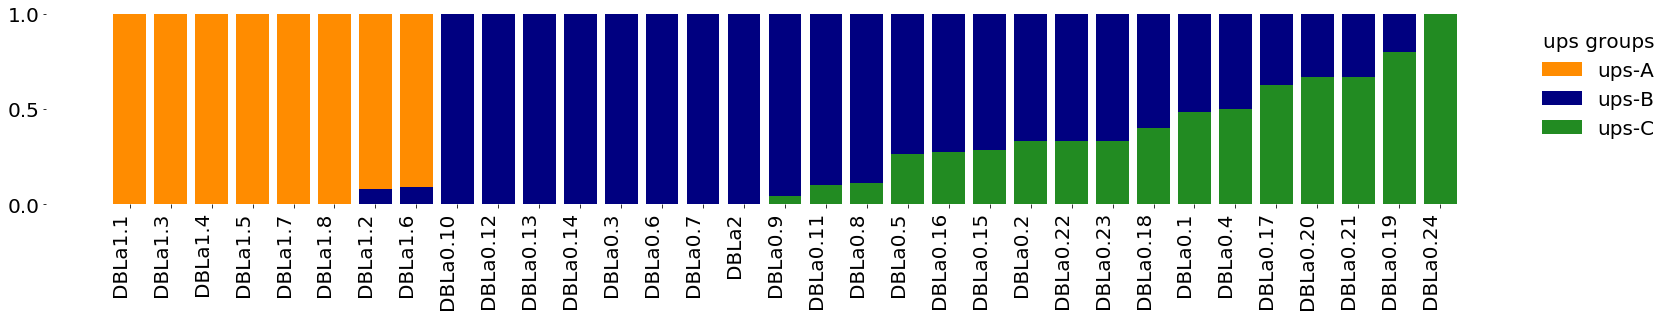

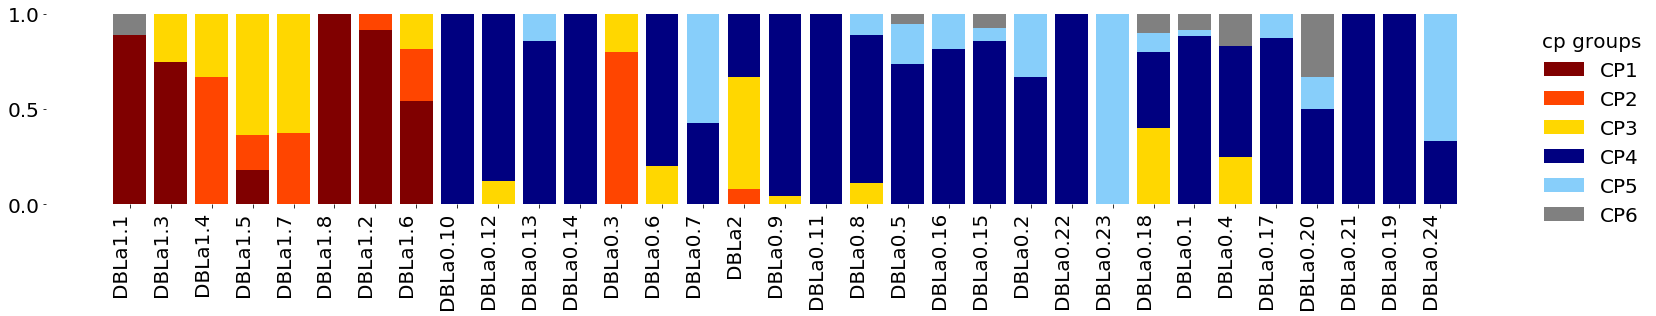

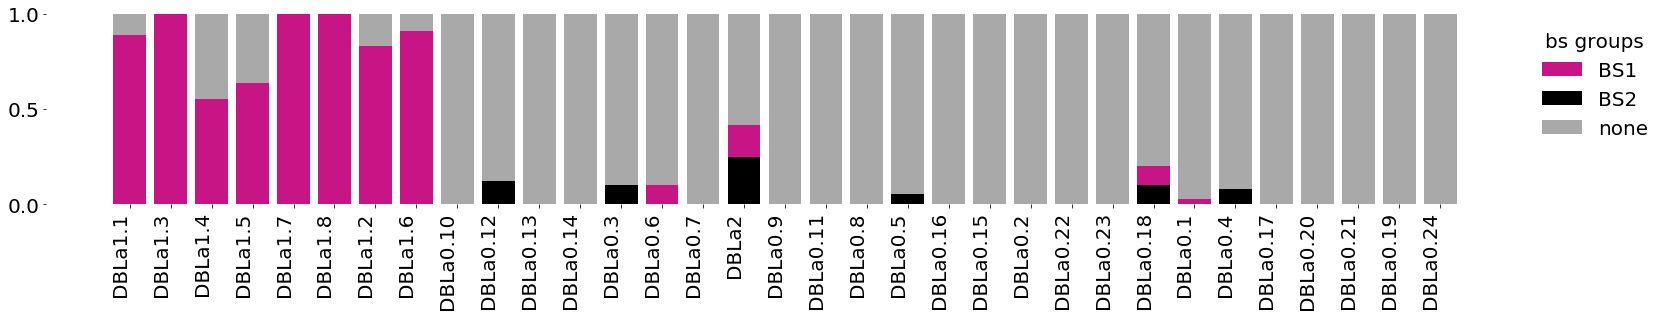

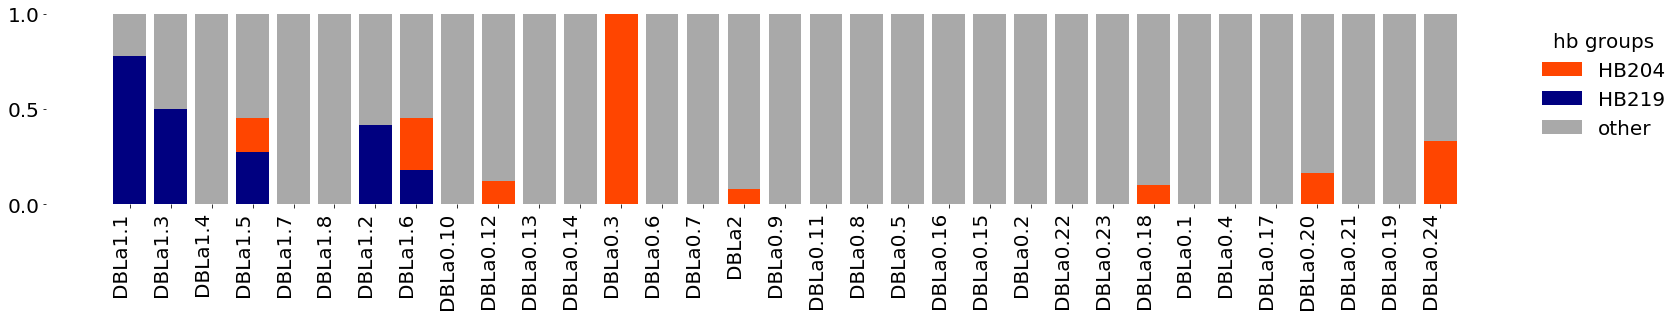

In [68]:
ups_bar(dbla_list, dbla_keys); plt.savefig("figures/dbla_ups.svg", format='svg', dpi=300, bbox_inches='tight', pad_inches = 1)
cp_bar(dbla_list, dbla_keys); plt.savefig("figures/dbla_cp.svg", format='svg', dpi=300, bbox_inches='tight', pad_inches = 1)
bs_bar(dbla_list, dbla_keys); plt.savefig("figures/dbla_bs.svg", format='svg', dpi=300, bbox_inches='tight', pad_inches = 1)
hb_bar(dbla_list, dbla_keys); plt.savefig("figures/dbla_hb.svg", format='svg', dpi=300, bbox_inches='tight', pad_inches = 1)
plt.show()

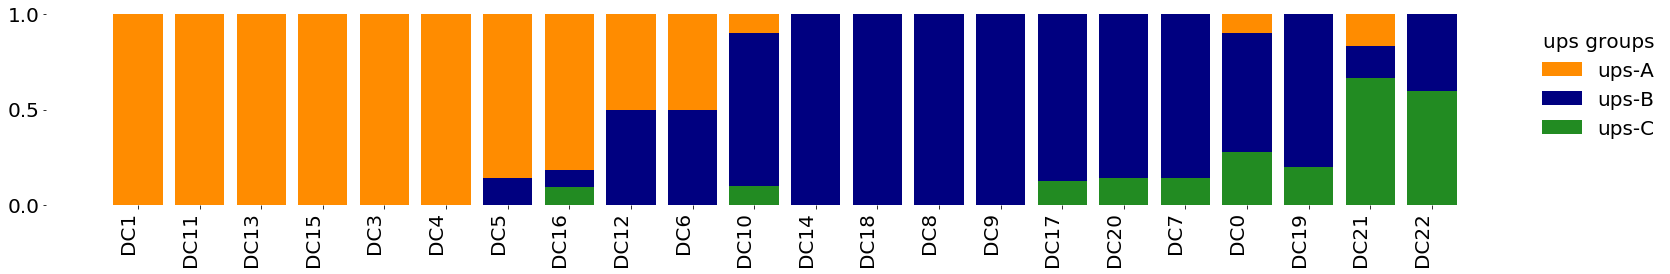

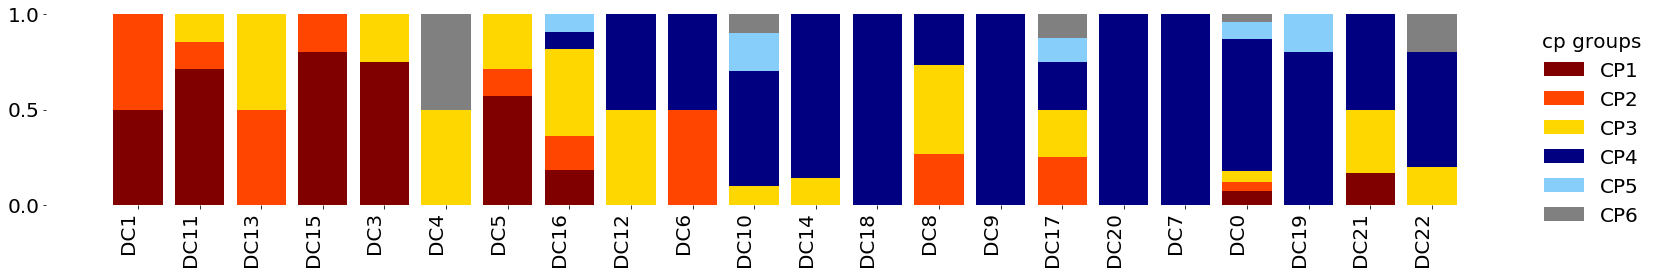

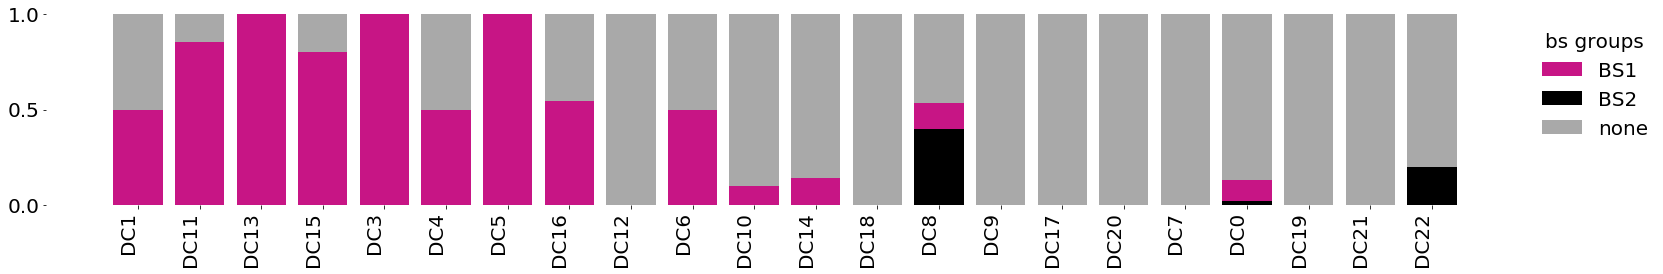

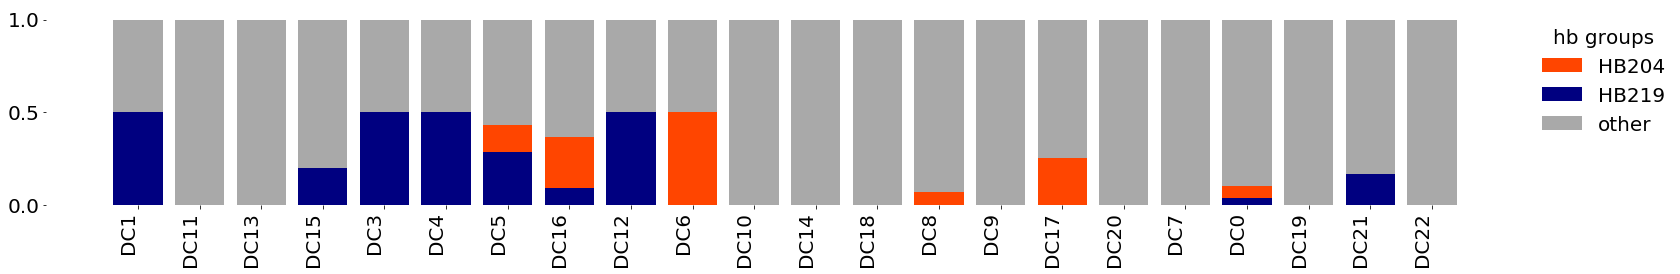

In [69]:
ups_bar(cassette_list, cassette_keys); plt.savefig("figures/cas_ups.svg", format='svg', dpi=300, bbox_inches='tight', pad_inches = 1)
cp_bar(cassette_list, cassette_keys); plt.savefig("figures/cas_cp.svg", format='svg', dpi=300, bbox_inches='tight', pad_inches = 1)
bs_bar(cassette_list, cassette_keys); plt.savefig("figures/cas_bs.svg", format='svg', dpi=300, bbox_inches='tight', pad_inches = 1)
hb_bar(cassette_list, cassette_keys); plt.savefig("figures/cas_hb.svg", format='svg', dpi=300, bbox_inches='tight', pad_inches = 1)
plt.show()

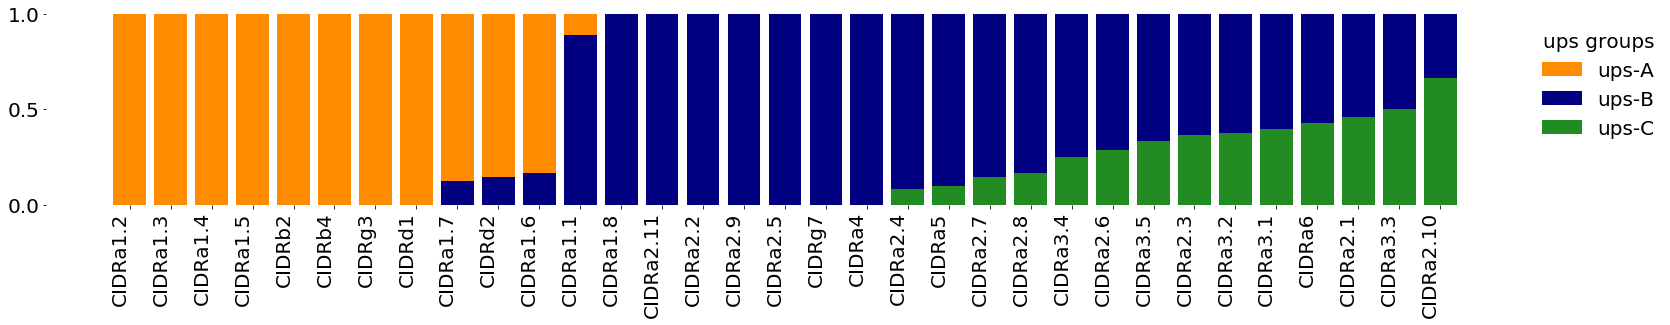

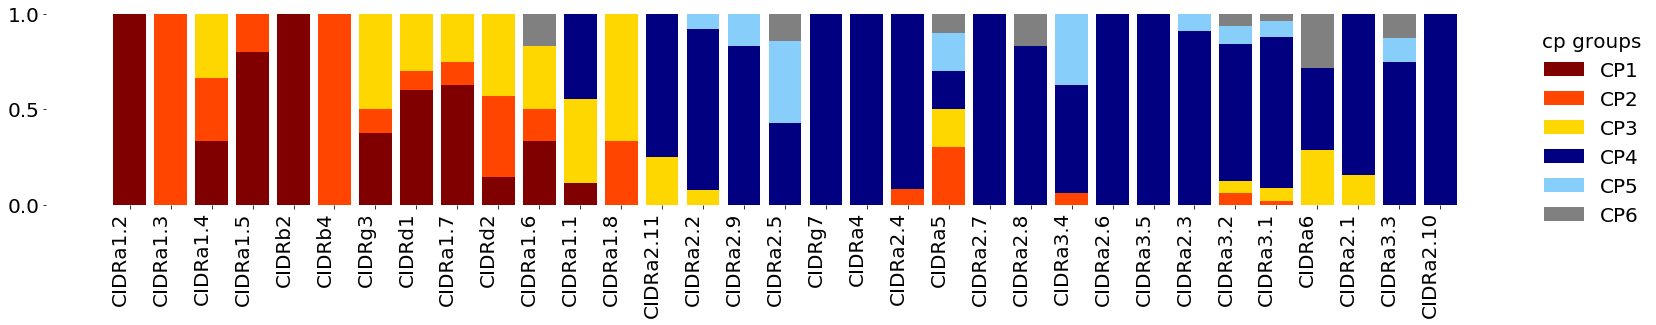

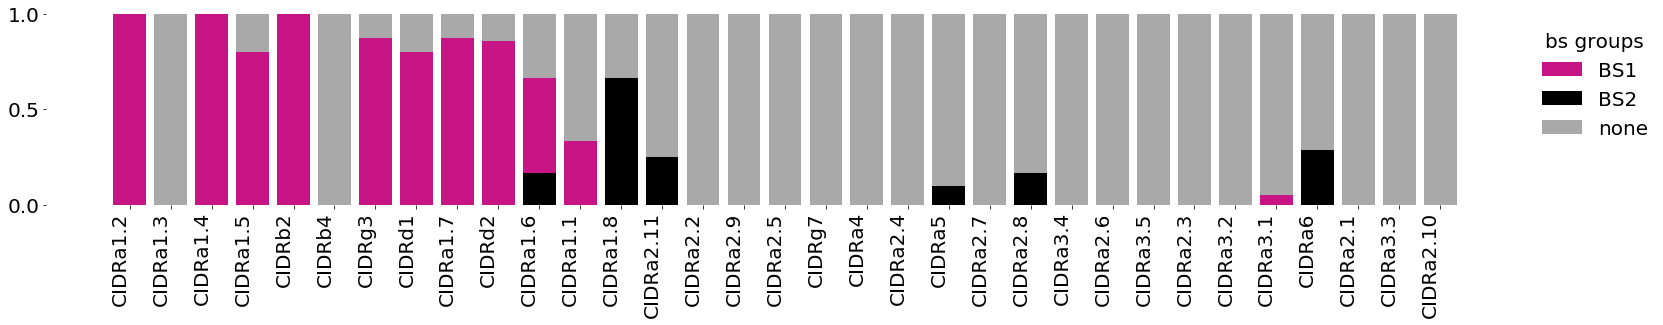

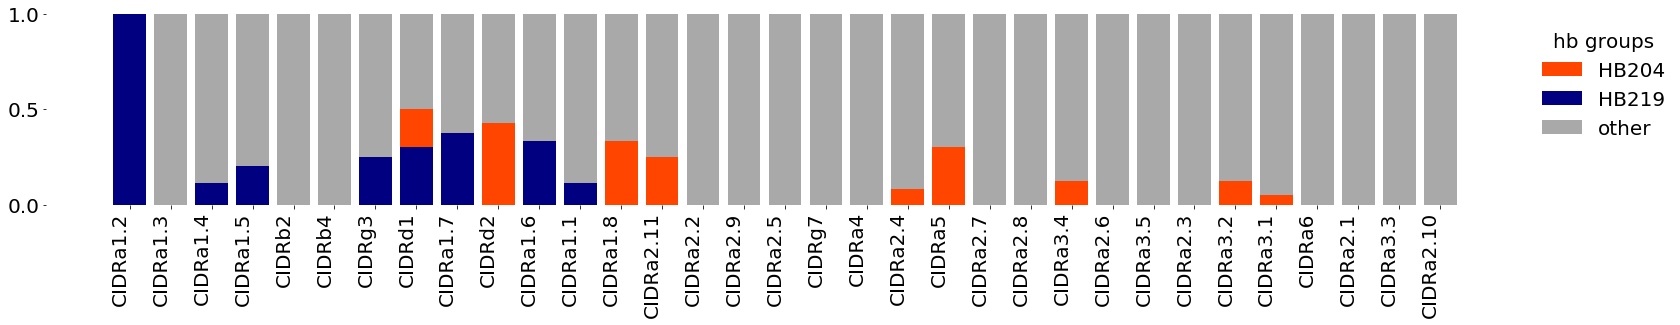

In [70]:
ups_bar(cidr_list, cidr_keys); plt.savefig("figures/cidr_ups.svg", format='svg', dpi=300, bbox_inches='tight', pad_inches = 1)
cp_bar(cidr_list, cidr_keys); plt.savefig("figures/cidr_cp.svg", format='svg', dpi=300, bbox_inches='tight', pad_inches = 1)
bs_bar(cidr_list, cidr_keys); plt.savefig("figures/cidr_bs.svg", format='svg', dpi=300, bbox_inches='tight', pad_inches = 1)
hb_bar(cidr_list, cidr_keys); plt.savefig("figures/cidr_hb.svg", format='svg', dpi=300, bbox_inches='tight', pad_inches = 1)
plt.show()

### ▶ Visualization 2: Networks

The block sharing network is partitioned by the cys/poLV group & block-sharing groups implemented above, and also by the classfications other researchers have done: ups, epcr binding, DC8/13/4/5, CD36 (data collected from Githinji, 2017 "curated_data_set.csv").

#### Get nodes & partition data from file

In [49]:
# Read in file that contains the node, tag, seq, and partition groups
df = pd.read_csv("processed_datasets/processed_data.csv") 
df.head(5)

,Node,Tag,Dbla Sequence,Cys/PoLV group,UPS group,EPCR,"DC8,13,4,5",CD36,BS
0,1,1,DIADIIRGKDLYLGDQERKQHLEKRLETMFEKIQKNNNNKLSNLST...,2,0,2,0,0,2
1,2,2,DIGDIIGGKDLYLDHEQGYNRLEARLKTIFQNIQNKNKSPLDKLSL...,2,0,2,0,0,2
2,3,3,DIGDIIRAKDLFIGYNQKDQNEKQKLQDSLKNIFGKIYEELSESAK...,4,0,2,0,0,0
3,4,4,DIGDIIRGEDLYLGYDDEEKKQREQLEENLKKIFKEIYDNLMEDLK...,6,0,2,0,0,0
4,5,5,DIGDIIRGIDMFKPNVHDKVEKGLREVFKKIHDLNKSKINDYDGDG...,1,0,2,0,0,1


In [50]:
# Put sequences into list (ordered)
sequences_list = df["Dbla Sequence"]

In [51]:
# Get nodes as number of sequences
nodes = range(len(sequences_list))

In [52]:
# Get network partition types as keys for dict below
partition_keys = list(df.columns[3:])

In [53]:
# Make ordered list of nodes/sequences, each contains a dictionary of partition group info
node_info = []
for node_i, sequence in enumerate(sequences_list):
    
    classifications = {partition_type : df[partition_type][node_i] for partition_type in partition_keys}

    processed_classifications = {}
    
    for key, val in classifications.items():
        
        # For "nan" values from csv columns
        if type(val) == np.float64:
            continue
            
        processed_classifications[key] = int(val)
    
    node_info.append({"sequence" : sequence, "classifications" : processed_classifications})

In [54]:
# Example of how list looks: info for first 2 sequences
node_info[:2]

[{'classifications': {'BS': 2,
   'CD36': 0,
   'Cys/PoLV group': 2,
   'DC8,13,4,5': 0,
   'EPCR': 2,
   'UPS group': 0},
  'sequence': 'DIADIIRGKDLYLGDQERKQHLEKRLETMFEKIQKNNNNKLSNLSTKEVREYWWALNRDQVWKAITCDAGAADEYFKKSGKLEFEFTGGQCGRDGENVPTYLDYVPQFFR'},
 {'classifications': {'BS': 2,
   'CD36': 0,
   'Cys/PoLV group': 2,
   'DC8,13,4,5': 0,
   'EPCR': 2,
   'UPS group': 0},
  'sequence': 'DIGDIIGGKDLYLDHEQGYNRLEARLKTIFQNIQNKNKSPLDKLSLDKFREYWWALNRVQVWKAITCKAEVDDIYSKTANGNTTLWNYNCGHHVNQDVPANLDYVPQFLR'}]

In [55]:
# Append node_info lists to main data dict
data["node_info"] = node_info

In [56]:
# Example of how to access info for a sequence in the data dict
data["node_info"][1]

{'classifications': {'BS': 2,
  'CD36': 0,
  'Cys/PoLV group': 2,
  'DC8,13,4,5': 0,
  'EPCR': 2,
  'UPS group': 0},
 'sequence': 'DIGDIIGGKDLYLDHEQGYNRLEARLKTIFQNIQNKNKSPLDKLSLDKFREYWWALNRVQVWKAITCKAEVDDIYSKTANGNTTLWNYNCGHHVNQDVPANLDYVPQFLR'}

In [57]:
# Now our main data dict has a dict of edge_info & a list of node_info
data.keys()

dict_keys(['edges_info', 'node_info'])

In [58]:
# Function to get edges 
def get_edges(data):
    tuple_list = []
    for item in data["edges_info"]:
        tuple_list.append(tuple(item["edge"]))
    return tuple_list  

edges_list = get_edges(data)

In [59]:
# Function to get lists of partition groups 
def get_partition_list(data, group_name):
    key = data["node_info"]
    class_list = []
    for i in range(len(key)): # node_info key is an ordered list
        cl = key[i]['classifications'][group_name]
        
        
        if group_name == "EPCR":
            if cl == 2:
                cl = 0
                class_list.append(cl)
            else:
                class_list.append(cl)
            
        else: 
            class_list.append(cl)
            
    return class_list    


partition_ids = ['Cys/PoLV group', 'UPS group', 'EPCR', 'DC8,13,4,5', 'CD36', 'BS']
partitions = {partition_id : get_partition_list(data, partition_id) for partition_id in partition_ids}

In [60]:
# Cys/PoLV & BS lists for full length var genes from 6 lab isolates (node 1236 to the end)
zeros = [0] * 1235 
cp_full = []
cp_full.extend(zeros)
cp_full.extend(df["Cys/PoLV group"][1235:])
cp_full = [int(i) for i in cp_full]

zeros = [0] * 1235 
bs_full = []
bs_full.extend(zeros)
bs_full.extend(df["BS"][1235:])
bs_full = [int(i) for i in bs_full]

# Add above lists to partitions dict
partitions["Cys/PoLV full"] = cp_full
partitions["BS full"] = bs_full

#### Use the webweb app to create network visuals:

In [61]:
list_edges = lambda x : [list(i["edge"]) for i in x]

In [62]:
adjList = list_edges(edges)
adjList[:3]

[[0, 50], [0, 51], [0, 120]]

In [63]:
def webweb(adjList, partitions_dict):
    from webweb.webweb import webweb
    
    web = webweb(num_nodes=N)
    web.networks.DM.adj = adjList
    
    
    # Set cyspolv partition
    web.networks.DM.labels.CysPoLV.type = "categorical"
    web.networks.DM.labels.CysPoLV.value = partitions_dict["Cys/PoLV group"]
    
    # Set cyspolv-full partition
    web.networks.DM.labels.CysPoLVfull.type = "categorical"
    web.networks.DM.labels.CysPoLVfull.value = partitions_dict["Cys/PoLV full"]
    
    # Set bs partition
    web.networks.DM.labels.BS.type = "categorical"
    web.networks.DM.labels.BS.value = partitions_dict["BS"]
    
    # Set bs-full partition
    web.networks.DM.labels.BSfull.type = "categorical"
    web.networks.DM.labels.BSfull.value = partitions_dict["BS full"]
    
    # Set ups partition
    web.networks.DM.labels.UPS.type = "categorical"
    web.networks.DM.labels.UPS.value = partitions_dict["UPS group"]
    
    # Set dc partition
    web.networks.DM.labels.DC.type = "categorical"
    web.networks.DM.labels.DC.value = partitions_dict["DC8,13,4,5"]
    
    # Set epcr partition
    web.networks.DM.labels.EPCR.type = "categorical"
    web.networks.DM.labels.EPCR.value = partitions_dict["EPCR"]
    
    # Set cd partition
    web.networks.DM.labels.CD.type = "categorical"
    web.networks.DM.labels.CD.value = partitions_dict["CD36"]

    
    web.draw()


In [64]:
webweb(adjList, partitions)

<b>Block-sharing network structure:</b> based on sequences matching four 10-aa PSPBs. Nodes/vertices that share PSPBs with one another are located in the same region. As seen in Bull, 2008 and Githinji, 2017, the network has 2 apparent major lobes: a large on and a smaller one (top right of large lobe). 

From Bull, 2008 (Figure 2D): 
<img src="paper_figs/bull_2008_network.png">

Webweb app network parameters for all networks: 
- Node charge: 5
- Link length: 10
- Link strength: 1
- Gravity: 0.1
- Node r: 4
- Zoom level: 1

Block-sharing network structure:
<img src="networks/network_struct.svg" width="350" height="350">

Network analysis of DBLa tags:

<img src="networks/network_cp.svg" style="float: left; width: 45%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="networks/network_cp_full.svg" style="float: left; width: 45%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="networks/network_bs.svg" style="float: left; width: 45%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="networks/network_bs_full.svg" style="float: left; width: 45%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="networks/network_ups.svg" style="float: left; width: 45%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="networks/network_dc.svg" style="float: left; width: 45%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="networks/network_epcr.svg" style="float: left; width: 45%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="networks/network_cd.svg" style="float: left; width: 45%; margin-right: 1%; margin-bottom: 0.5em;">


Network analysis of DBLa tags from known DC8 var genes:

In [65]:
# Get known DC8 var genes tags
tags_nodes = ["RAJ116var08", "IT4var06", "IGHvar19", "MAL6P1.316", "PFCLINvar30",
       "PF08_0140", "RAJ116var11", "PFCLINvar31",
       "DD2var47", "IT4var20",
       "IT4var19", "IT4var32b",
       "C4187A_G2_109_0232", "C4140A_G2_110_0242", "C4187B_G2_795_1575", 
       "1983_3", "1983_1", "1965_1"]

In [66]:
dc8_nodes = []
dc8_ind = []
bs_dc8 = []
for i,tag in enumerate(df.Tag):
    if tag in tags_nodes:
        if tag == "C4187A_G2_109_0232":
            tag_new = "4187_dom1"
            dc8_nodes.append(tag_new)
            dc8_ind.append(i)
            bs_dc8.append(df.BS[i])
            
        elif tag == "C4140A_G2_110_0242":
            tag_new = "4140_dom"
            dc8_nodes.append(tag_new)
            dc8_ind.append(i)
            bs_dc8.append(df.BS[i])
        
        elif tag == "C4187B_G2_795_1575":
            tag_new = "4187_dom2"
            dc8_nodes.append(tag_new)
            dc8_ind.append(i)
            bs_dc8.append(df.BS[i])
        
        else:
            dc8_nodes.append(tag)
            dc8_ind.append(i)
            bs_dc8.append(df.BS[i])
bs_dc8 = [int(i) for i in bs_dc8]

In [67]:
for i in range(len(dc8_nodes)):
    print(dc8_ind[i])
    print(dc8_nodes[i])
    print(bs_dc8[i])
    print("")

1226
1983_3
2

1227
1983_1
2

1228
1965_1
2

1229
4187_dom1
2

1230
4187_dom2
2

1232
4140_dom
2

1274
DD2var47
0

1337
IGHvar19
1

1363
IT4var06
1

1373
IT4var19
0

1374
IT4var20
0

1384
IT4var32b
0

1407
MAL6P1.316
0

1422
PF08_0140
2

1451
PFCLINvar30
0

1452
PFCLINvar31
2

1519
RAJ116var08
0

1522
RAJ116var11
2



In [68]:
dc_tups = []
for j in edges_list:
    for ind in dc8_ind:
        if ind == j[0] or ind == j[1]:
            if j[0] in dc8_ind and j[1] in dc8_ind:
                dc_tups.append(j)

In [69]:
set(dc_tups)

{(1226, 1227),
 (1226, 1229),
 (1226, 1230),
 (1226, 1232),
 (1227, 1229),
 (1227, 1230),
 (1227, 1232),
 (1228, 1229),
 (1228, 1230),
 (1229, 1230),
 (1229, 1232),
 (1230, 1232),
 (1274, 1374),
 (1373, 1384),
 (1422, 1522),
 (1452, 1522)}

Using Gephi, we get this network that replicates Githinji & Bull 2017:
<br><br>
<img src="figures/dc8_network.png">

### ▶ Visualization 3: Operator Receiver Curves

Get cys2 group from "cys2_records" list created above:

In [70]:
cys2_seqs = []
for i in range(len(cys2_records)):
    cys2_seqs.append(cys2_records[i].name)

In [71]:
cysteines2 = []; 
for i in range(len(sequences_list)):
    if str(Name[i]) in cys2_seqs:
        cysteines2.append(i)

In [72]:
# List of CIDRa1's:
CIDRs = ["CIDRa1.1","CIDRa1.2","CIDRa1.3","CIDRa1.4","CIDRa1.5","CIDRa1.6","CIDRa1.7","CIDRa1.8"]

In [73]:
# Tag classifiers used as predictors 
cys2bs1 = []; CP1 = []; cys2bs1_CP1 = []; cys2 = []
# Full sequence classifiers, to be predicted by tag classifiers
group_A = [];  DC8 = []; DC13 = []; CIDRa1 = [];

In [74]:
# Fill in lists above, order based on curated dataset
for i in range(len(sequence)):
    
    # Exclude genomes 3D7 and IT4 seq's that were used for BS classifs
    if genome[i] != "3D7" and genome[i] != "IT4":

        group_A.append(1) if ups[i] == "A" else group_A.append(0)
        CP1.append(1) if cys_PoLV_group[i] == 1 else CP1.append(0)      
        CIDRa1.append(1) if CIDR[i] in CIDRs else CIDRa1.append(0)
        cys2bs1.append(1)  if BS_group1[i] == 1 and i in cysteines2 else cys2bs1.append(0)  
        cys2bs1_CP1.append(1) if cys_PoLV_group[i] == 1 or (BS_group1[i] == 1 and i in cysteines2) else cys2bs1_CP1.append(0) 

        cys2.append(1) if i in cysteines2 else cys2.append(0)
        DC13.append(1) if cassette[i] == "DC13" else DC13.append(0)
        DC8.append(1) if cassette[i] == "DC8" else DC8.append(0)

In [75]:
# Function to calculate FPR and TPR and plot ROC curve
def model_roc(predictor, response, color, legend_label):
    
    # Turn predictor and response lists to arrays & reshape them (-1,1)
    predictor_array = np.array(predictor).reshape(-1, 1)
    response_array = np.array(response).reshape(-1, 1)
    
    # Make log regression model & fit training data to train
    model = LogisticRegression()
    model.fit(predictor_array, response_array)
     
    # Predict probabilities
    pred_probs = model.predict_proba(predictor_array)[:,1]
    
    # ROC curve & AUC
    fpr, tpr, threshold = metrics.roc_curve(response_array, pred_probs)
    roc_auc = metrics.auc(fpr, tpr)
    
    # Scoring model
    model_score = model.score(predictor_array, response_array)
    
    
    plt.plot(fpr, tpr, color=color,
             lw=2, label= legend_label + ' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkgray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right", prop={'size':10})

In [76]:
import plotly.tools as tls

mpl.rcParams.update({'font.size': 13})
mpl.rc('figure', figsize=(11, 9))

fig = plt.figure()


ax1 = fig.add_subplot(221)
model_roc(cys2bs1, group_A, "crimson", "groupA ~ cys2bs1")
model_roc(cys2bs1_CP1, group_A, "dodgerblue", "groupA ~ cys2bs1_CP1")
model_roc(cys2, group_A, "dimgray", "groupA ~ cys2")
plt.title('Predicting upsA from DBLa tags')


ax2 = fig.add_subplot(222)
model_roc(cys2bs1, DC8, "crimson", "DC8 ~ cys2bs1")
model_roc(cys2bs1_CP1, DC8, "dodgerblue", "DC8 ~ cys2bs1_CP1")
model_roc(cys2, DC8, "dimgray", "DC8 ~ cys2")
plt.title('Predicting DC8 from DBLa tags')

ax3 = fig.add_subplot(223)
model_roc(cys2bs1, DC13, "crimson", "DC13 ~ cys2bs1")
model_roc(cys2bs1_CP1, DC13, "dodgerblue", "DC13 ~ cys2bs1_CP1")
model_roc(cys2, DC13, "dimgray", "DC13 ~ cys2")
plt.title('Predicting DC13 from DBLa tags')


ax4 = fig.add_subplot(224)
model_roc(cys2bs1, CIDRa1, "crimson", "CIDRa1 ~ cys2bs1")
model_roc(cys2bs1_CP1, CIDRa1, "dodgerblue", "CIDRa1 ~ cys2bs1_CP1")
model_roc(cys2, CIDRa1, "dimgray", "CIDRa1 ~ cys2")
plt.title('Predicting CIDRa1 from DBLa tags')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)


/Users/dieumynguyen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

